# Разработка системы распознавания предметов интерьера в потоковом видео
## Часть 7: Предсказания

In [4]:
%matplotlib inline

# System
import os
import sys
import datetime
import time

# Base
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from skimage.io import imread, imshow
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN

# Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout, BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger

# Preprocessing
from keras.utils import Sequence, to_categorical
from keras.utils.vis_utils import plot_model

# Backend
import tensorflow as tf
from keras import backend as K
from tensorflow.python.client import device_lib

# Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [5]:
from scripts_.PathFinder import PathFinder
from scripts_.SegEncoder import SegEncoder
from scripts_.ClassList import ClassList

pf = PathFinder()
se = SegEncoder()
cl = ClassList(load_class_encode=True, class_encode_path="static/class_encode.txt")

img_dir = 'data/ADE20K_filtred/images/'

## Загрузка модели 

In [6]:
class def_config:

    main_data_dir = "data/ADE20K_encoded/"
    callbacks_dir = "callbacks/"

    img_shape = 256
    classes_num = 17

    batch_size = 4
    epoch_num = 1
    train_coef = 1
    learning_rate = 0.0001

    last_activation = "sigmoid"
    loss_function = "categorical_crossentropy"

    layers_in_block = 3
    dropout_prob = 0.1
    
    gpu_memory_limit = 0.8
    cpu_threads_num = 4

    callbacks_monitor = "val_jaccard_coef"
    callbacks_data_format = "%m.%d_%H-%M"
    file_name = "DefName"
    
    is_load = True
    weight_path = "callbacks/Unet_1024_dropout_nearest_3_06.11_15-44/best_w_jaccard.h5"
    
    argparse_is_on = False
    
    
args = def_config()

In [7]:
main_data_dir = args.main_data_dir

train_dir = main_data_dir + "train/"
val_dir = main_data_dir + "val/"

img_train_dir = train_dir + "img/"
mask_train_dir = train_dir + "mask/"

img_val_dir = val_dir + "img/"
mask_val_dir = val_dir + "mask/"

####################################

img_shape = args.img_shape
batch_size = args.batch_size
classes_num = args.classes_num

epoch_num = args.epoch_num
train_coef = args.train_coef
learning_rate = args.learning_rate

loss_function = args.loss_function
last_activation = args.last_activation

layers_in_block = args.layers_in_block
dropout_prob = args.dropout_prob


is_load = args.is_load
if is_load:
    weight_path = args.weight_path
else:
    weight_path = None
    
train_size = len(os.listdir(path=train_dir + "img/"))
val_size = len(os.listdir(path=val_dir + "img/"))

In [8]:
def data_gen(img_dir, mask_dir, classes_num, batch_size):
    img_folder = img_dir
    mask_folder = mask_dir

    img_list = os.listdir(img_folder)
    random.shuffle(img_list)
    img_dir_size = len(img_list)

    for i in range(len(img_list)):
        img_list[i] = img_list[i].split(".")[0]  # отделяем имя от формата

    counter = 0
    while (True):
        img = np.zeros((batch_size, img_shape, img_shape, 3)).astype('float')
        mask = np.zeros((batch_size, img_shape, img_shape, classes_num)).astype("uint8")

        for i in range(counter, counter + batch_size):
            train_img = cv2.imread(img_folder + '/' + img_list[i] + ".jpg") / 255.
            train_img = cv2.resize(train_img, (img_shape, img_shape))

            img[i - counter] = train_img

            train_mask = cv2.imread(mask_folder + '/' + img_list[i] + ".png", cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (img_shape, img_shape), interpolation=cv2.INTER_NEAREST)
            train_mask = train_mask.reshape(img_shape, img_shape, 1)
            train_mask = to_categorical(train_mask, num_classes=classes_num)

            mask[i - counter] = train_mask

        counter += batch_size

        if counter + batch_size >= img_dir_size:
            counter = 0
            random.shuffle(img_list)

        yield img, mask


train_gen = data_gen(img_train_dir, mask_train_dir, classes_num=classes_num, batch_size=batch_size)
val_gen = data_gen(img_val_dir, mask_val_dir, classes_num=classes_num, batch_size=batch_size)

In [9]:
def conv_block(filters, layers, input_layer):
    output_layer = input_layer
    
    for i in range(layers):
        output_layer = Conv2D(filters, (3, 3), padding="same")(output_layer)
        output_layer = Activation("relu")(output_layer)
    
    output_layer = Dropout(dropout_prob)(output_layer)
    return output_layer


def get_model(img_shape, classes_num, last_activation, layers_in_block):
    block0_input = Input(shape=(img_shape, img_shape, 3))
    
    block1_conv = conv_block(64, layers_in_block, block0_input)
    block1_pool = MaxPool2D(2)(block1_conv)

    block2_conv = conv_block(128, layers_in_block, block1_pool)
    block2_pool = MaxPool2D(2)(block2_conv)

    block3_conv = conv_block(256, layers_in_block, block2_pool)
    block3_pool = MaxPool2D(2)(block3_conv)
    
    block4_conv = conv_block(512, layers_in_block, block3_pool)
    block4_pool = MaxPool2D(2)(block4_conv)
    
    block5_conv = conv_block(1024, layers_in_block, block4_pool)
    block5_upsa = UpSampling2D(2, interpolation="nearest")(block5_conv)

    block6_conc = Concatenate()([block4_conv, block5_upsa])    

    block6_conv = conv_block(512, layers_in_block, block6_conc)
    block6_upsa = UpSampling2D(2, interpolation="nearest")(block6_conv)
    
    block7_conc = Concatenate()([block3_conv, block6_upsa])
    
    block7_conv = conv_block(256, layers_in_block, block7_conc)
    block7_upsa = UpSampling2D(2, interpolation="nearest")(block7_conv)

    block8_conc = Concatenate()([block2_conv, block7_upsa])
    
    block8_conv = conv_block(128, layers_in_block, block8_conc)
    block8_upsa = UpSampling2D(2, interpolation="nearest")(block8_conv)

    block9_conc = Concatenate()([block1_conv, block8_upsa])
    
    block9_conv = conv_block(64, layers_in_block, block9_conc)

    block10_output = Conv2D(classes_num, (1, 1), padding="same", activation=last_activation)(block9_conv)

    return Model(inputs=block0_input, outputs=block10_output)

In [10]:
model = get_model(None, classes_num, last_activation, layers_in_block=layers_in_block)

model.load_weights(weight_path)

if is_load:
    if not weight_path:
        raise ValueError("Don't load weight_path")
    model.load_weights(weight_path)

### Площадь классов

In [11]:
with open("static/class_areas.txt", "r") as f:
    class_area = []
    for line in f:
        index, area, name = line.split("\t")
        class_area.append(float(area))
class_area

[0.6956444619313632,
 0.06796820754441062,
 0.031829947815483456,
 0.12452434979147624,
 0.05857641754989444,
 0.0656949052493119,
 0.022375359046335207,
 0.18965312282745642,
 0.06782081669336495,
 0.07111176502670331,
 0.026140747622167438,
 0.06318798501982943,
 0.040565138596754806,
 0.09994068145751953,
 0.038634684290821196,
 0.07160829352122053,
 0.10486493791852679]

## Предсказания

In [14]:
def get_share(pred):
    return pred.sum() / pred.shape[0] / pred.shape[1]

def get_new_img(original_img, clipping=0.5):
    h, w, c = original_img.shape
    img = cv2.resize(original_img / 255., (img_shape, img_shape))
    
    pred = model.predict(np.array([img]))[0]
    
    new_img = original_img.copy()
    
    for i in range(1, classes_num):
        mask = pred[:, :, i]

        if get_share(mask) < class_area[i]*0.5:
            continue

        print(cl.class_list[i])
        print(get_share(mask), "-", class_area[i])

        mask = cv2.resize(mask, (w, h))

        
        mask = (mask > clipping).astype(np.uint8)
        neg = 1 - mask

        index = i % 3
        free = [0, 1, 2]
        free.remove(index)
        new_img[:, :, index] += mask*255
        new_img[:, :, free[0]] *= neg
        new_img[:, :, free[1]] *= neg

        new_img = np.clip(new_img, 0, 255)
    return new_img

['table', 'desk']
0.04876050725579262 - 0.05857641754989444
['bed', 'sofa, couch, lounge', 'cushion', 'pillow']
0.23124028742313385 - 0.18965312282745642


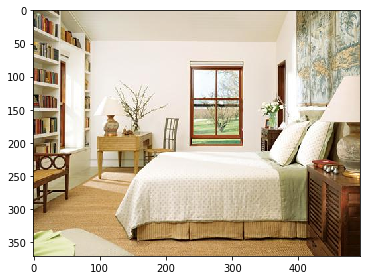

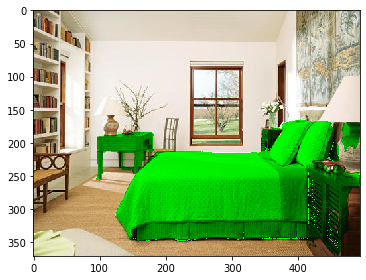

CPU times: user 492 ms, sys: 37.8 ms, total: 530 ms
Wall time: 532 ms


In [15]:
%%time
path = val_dir + "/img/00001152.jpg"
original = cv2.imread(path)

new_img = get_new_img(original)

original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
imshow(original)
plt.show()

new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
imshow(new_img)
plt.show()

## Получение рамки

In [97]:
blue = (255, 0, 0)
green = (0, 255, 0)
red = (0, 0, 255)
color = [blue, green, red]

def get_border(mask):
    x, y = np.where(mask == 1)
    
    down = x.min()
    up = x.max()

    left = y.min()
    right = y.max()
    
    return down, up, left, right

def get_new_img(original_img, clipping=0.5, class_area_coef=0.5):
    h, w, c = original_img.shape
    img = cv2.resize(original_img / 255., (img_shape, img_shape))
    
    pred = model.predict(np.array([img]))[0]
    
    new_img = original_img.copy()
    
    index_border_color = dict()
    
    free_color = [0, 1, 2]
    for i in range(1, classes_num):
        mask = pred[:, :, i]

        if get_share(mask) < class_area[i] * class_area_coef:
            continue

        mask = cv2.resize(mask, (w, h))
        
        mask = (mask > clipping).astype(np.uint8)
        down, up, left, right = get_border(mask)
        
        
        neg = 1 - mask

        color_index = i % 3
        if color_index in free_color:
            free_color.remove(color_index)
            if len(free_color) == 0:
                free_color = [0, 1, 2]
        else:
            color_index = free_color[0]
        index_border_color[i] = [down, up, left, right, color_index]
            
        free = [0, 1, 2]
        free.remove(color_index)
        new_img[:, :, color_index] += mask*255
        new_img[:, :, free[0]] *= neg
        new_img[:, :, free[1]] *= neg

        new_img = np.clip(new_img, 0, 255)
    return new_img, index_border_color

{4: [178, 368, 95, 492, 1], 7: [165, 355, 125, 492, 0]}


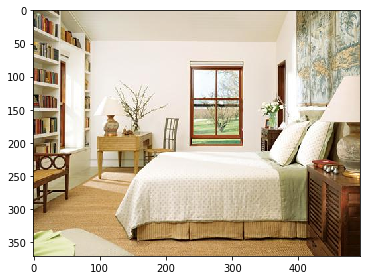

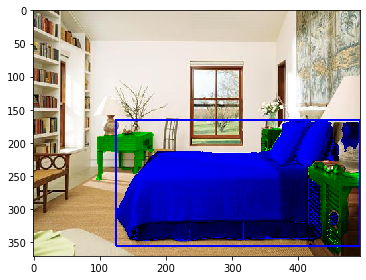

CPU times: user 543 ms, sys: 36.1 ms, total: 579 ms
Wall time: 552 ms


In [25]:
%%time
path = val_dir + "/img/00001152.jpg"
original = cv2.imread(path)

new_img, index_border = get_new_img(original)

print(index_border)

original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
imshow(original)
plt.show()

down, up, left, right, color_index  = index_border[7]
cv2.rectangle(new_img, (right, up), (left, down), 
            color[color_index], thickness=2, lineType=8, shift=0)

new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
imshow(new_img)
plt.show()

## Выбросы 

### Порог для вероятности 

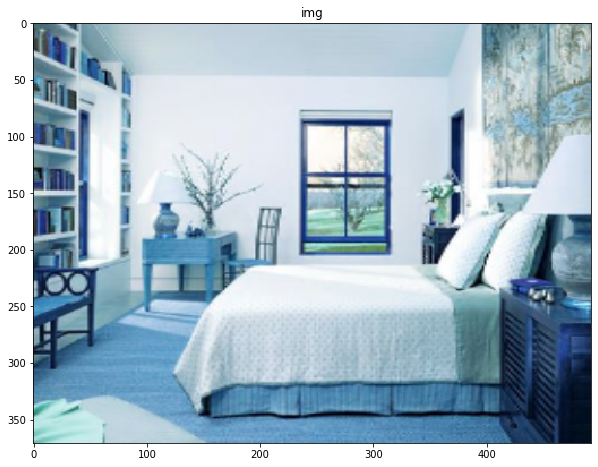

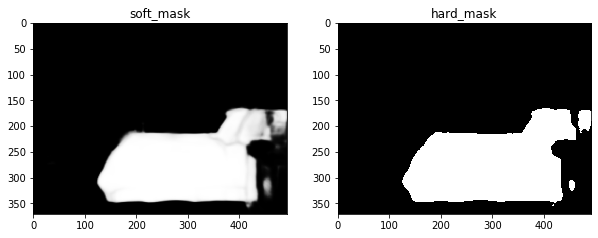

In [14]:
path = val_dir + "/img/00001152.jpg"
original_img = cv2.imread(path)

h, w, c = original_img.shape
img = cv2.resize(original_img / 255., (img_shape, img_shape))

pred = model.predict(np.array([img]))[0]

mask = pred[:, :, 7]
original_img = cv2.resize(img, (w, h))
mask = cv2.resize(mask, (w, h))

# Изображение
plt.figure(figsize=(10, 10))
plt.imshow(original_img), plt.title("img")
plt.show()

# Маски
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(mask, "gray"), plt.title("soft_mask")
plt.subplot(122), plt.imshow(mask > 0.5, "gray"), plt.title('hard_mask')
plt.show()

### Квантили 

271.0801469904177
304.34179923713833


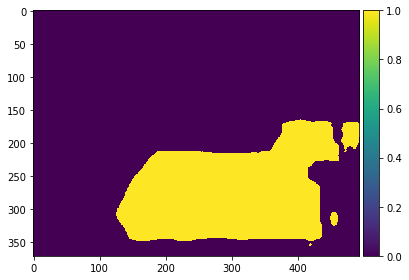

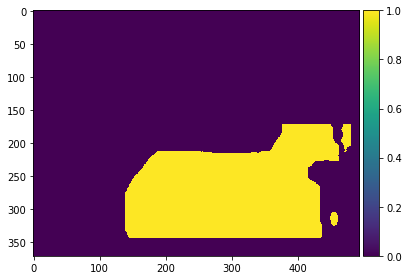

In [29]:
path = val_dir + "/img/00001152.jpg"
original_img = cv2.imread(path)

h, w, c = original_img.shape
img = cv2.resize(original_img / 255., (img_shape, img_shape))

pred = model.predict(np.array([img]))[0]

mask = pred[:, :, 7]
mask = cv2.resize(mask, (w, h))
        
mask = (mask > 0.5).astype(np.uint8)

x, y = np.where(mask == 1)

print(np.average(x))
print(np.average(y))

alpha = 0.01
down = int(np.quantile(x, q=alpha))
up = int(np.quantile(x, q=1-alpha))

left = int(np.quantile(y, q=alpha))
right = int(np.quantile(y, q=1-alpha))

filt_mask = mask.copy()

imshow(mask)
plt.show()

filt_mask[:down, :] = filt_mask[up:, :] = filt_mask[:, :left] = filt_mask[:, right:] = 0

imshow(filt_mask)
plt.show()

In [18]:
def get_quantile(mask, alpha = 0.02):
    x, y = np.where(mask == 1)
    
    down = int(np.quantile(x, q=alpha))
    up = int(np.quantile(x, q=1-alpha))

    left = int(np.quantile(y, q=alpha))
    right = int(np.quantile(y, q=1-alpha))
    
    return down, up, left, right

def get_new_img(original_img, clipping=0.5, class_area_coef=0.5):
    h, w, c = original_img.shape
    img = cv2.resize(original_img / 255., (img_shape, img_shape))
    
    pred = model.predict(np.array([img]))[0]
    
    new_img = original_img.copy()
    
    index_border_color = dict()
    
    index = round_index(0)
    free_color = [0, 1, 2]
    for i in range(1, classes_num):
        mask = pred[:, :, i]

        if get_share(mask) < class_area[i] * class_area_coef:
            continue

        mask = cv2.resize(mask, (w, h))
        
        mask = (mask > clipping).astype(np.uint8)
        
        down, up, left, right = get_quantile(mask)
        mask[:down, :] = mask[up:, :] = mask[:, :left] = mask[:, right:] = 0        
        
        neg = 1 - mask

        color_index = i % 3
        if color_index in free_color:
            free_color.remove(color_index)
            if len(free_color) == 0:
                free_color = [0, 1, 2]
        else:
            color_index = free_color[0]
        index_border_color[i] = [down, up, left, right, color_index]
            
        free = [0, 1, 2]
        free.remove(color_index)
        new_img[:, :, color_index] += mask*255
        new_img[:, :, free[0]] *= neg
        new_img[:, :, free[1]] *= neg

        new_img = np.clip(new_img, 0, 255)
    return new_img, index_border_color

#### Разные метрики  

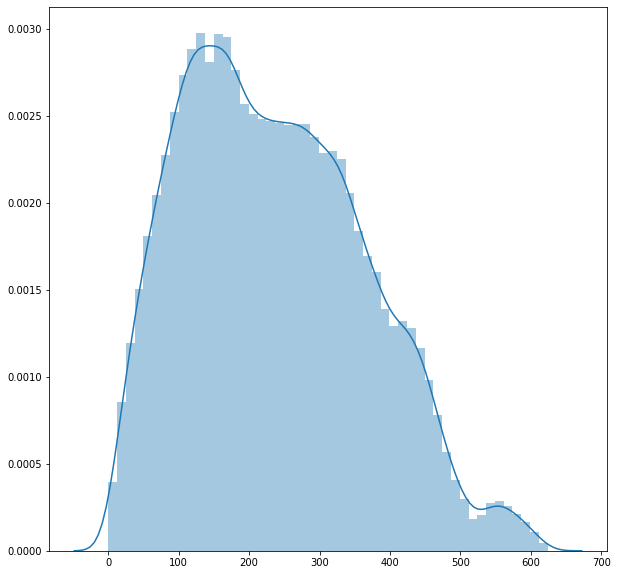

In [59]:
plt.figure(figsize=(10, 10))
sns.distplot(dist)
plt.show()

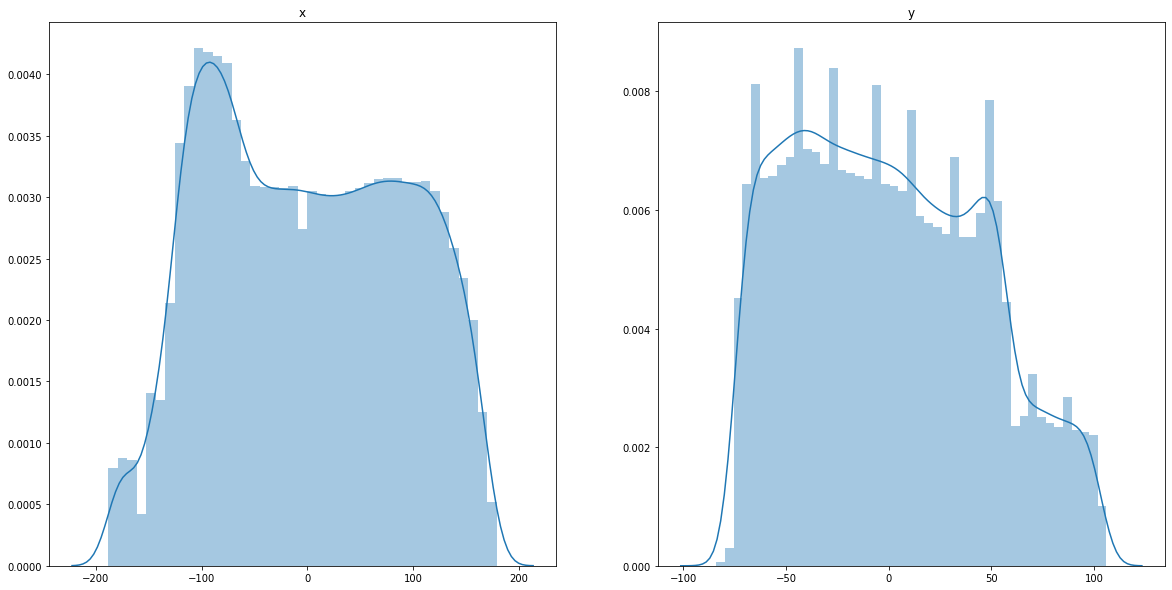

In [60]:
# Маски
plt.figure(figsize=(20, 10))
plt.subplot(121), sns.distplot(xy[:, 1]), plt.title("x")
plt.subplot(122), sns.distplot(xy[:, 0]), plt.title('y')
plt.show()

## Кластеризация

In [102]:
def get_db_mask(mask, eps=1):
    x,y = np.where(mask == 1)

    arr = np.empty((x.shape[0], 2), dtype=np.uint(8))
    arr[:, 0] = x
    arr[:, 1] = y

    clustering = DBSCAN(eps=eps, min_samples=1).fit(arr)
    clustering.labels_

    target = stats.mode(clustering.labels_).mode[0]
    new_mask = np.zeros(mask.shape, dtype=np.uint8)

    for i in range(len(arr)):
        if clustering.labels_[i] != target:
            continue
        xx, yy = arr[i]
        new_mask[xx, yy] = 1
    return new_mask

In [103]:
%%time 
get_db_mask(mask)

CPU times: user 375 ms, sys: 3.75 ms, total: 379 ms
Wall time: 378 ms


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


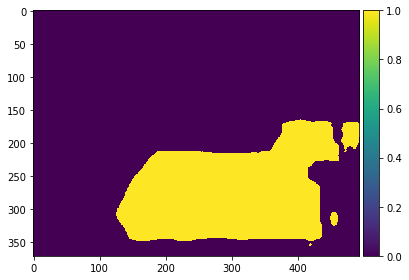

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


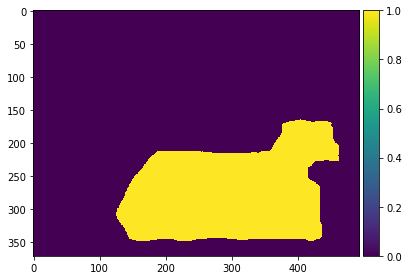

CPU times: user 820 ms, sys: 11.6 ms, total: 832 ms
Wall time: 830 ms


In [104]:
%%time
imshow(mask)
plt.show()

imshow(get_db_mask(mask))
plt.show()

In [105]:
def get_new_img(original_img, clipping=0.5, class_area_coef=0.5, db_eps=1):
    h, w, c = original_img.shape
    img = cv2.resize(original_img / 255., (img_shape, img_shape))
    
    pred = model.predict(np.array([img]))[0]
    
    new_img = original_img.copy()
    
    index_border_color = dict()
    
    free_color = [0, 1, 2]
    for i in range(1, classes_num):
        mask = pred[:, :, i]

        if get_share(mask) < class_area[i] * class_area_coef:
            continue

        mask = (mask > clipping).astype(np.uint8)
        mask = get_db_mask(mask, db_eps)
        
        mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_LINEAR)
        
        
        down, up, left, right = get_border(mask)
        mask[:down, :] = mask[up:, :] = mask[:, :left] = mask[:, right:] = 0        
        
        neg = 1 - mask

        color_index = i % 3
        if color_index in free_color:
            free_color.remove(color_index)
            if len(free_color) == 0:
                free_color = [0, 1, 2]
        else:
            color_index = free_color[0]
        index_border_color[i] = [down, up, left, right, color_index]
            
        free = [0, 1, 2]
        free.remove(color_index)
        new_img[:, :, color_index] += mask*255
        new_img[:, :, free[0]] *= neg
        new_img[:, :, free[1]] *= neg

        new_img = np.clip(new_img, 0, 255)
    return new_img, index_border_color

## Обработка видео 

In [110]:
def start_video(video_in='data/test1.mp4', video_out='test2.avi', fps=10,
                clipping=0.5, class_area_coef=0.5, db_eps=1):
    cap = cv2.VideoCapture(video_in)

    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out = cv2.VideoWriter(video_out, fourcc, fps, (1280, 720))

    frame_count = 0
    while(cap.isOpened()):
        frame_count += 1
        ret, frame = cap.read()
        if not ret:
            break

        new_img, index_border = get_new_img(frame, clipping=clipping, class_area_coef=class_area_coef)

        for index, border_color  in index_border.items():
            down, up, left, right, color_index  = border_color

            cv2.rectangle(new_img, (right, up), (left, down), 
                          color[color_index], thickness=2, lineType=8, shift=0)
            cv2.putText(new_img, str(cl.class_list[index][0]), (left + 4, down + 20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color[color_index], 2)

        cv2.imshow('frame', new_img)
        out.write(new_img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    out.release()
    cap.release()
    cv2.destroyAllWindows()
    
    return frame_count

In [113]:
%%time
start_video(video_in='data/test5.mp4', video_out='demo/test5.avi', fps=10,
                clipping=0.5, class_area_coef=0.50, db_eps=1)

CPU times: user 3min 23s, sys: 24.9 s, total: 3min 48s
Wall time: 3min 21s


939